In [1]:
from graphviz import Digraph

In [2]:
class Value:
    def __init__(self, data, prev=(), op='', label=''):
        self.grad = 0

        if hasattr(data, 'data'):
            self.data = data.data
            self._prev = data.prev
            self._op = data.op
        else:
            self.data = data
            self._prev = set(prev)
            self._op = op

        self._label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    @property
    def label(self):
        if not self._label and self._prev:
            return f"({[n.label for n in self._prev]})"
        return self._label

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op


In [3]:
a = Value(2., label='a')
b = Value(-3., label='b')
a + b

Value(data=-1.0, label=(['a', 'b']))

In [4]:
a.__add__(b)

Value(data=-1.0, label=(['a', 'b']))

In [5]:
a * b

Value(data=-6.0, label=(['a', 'b']))

In [6]:
c = Value(10, label='c')
e = Value(a*b, label='e')
d = Value(e + c, label='d')
d

Value(data=4.0, label=d)

In [7]:
# (a*b), (c)
d.prev

{Value(data=-6.0, label=e), Value(data=10, label=c)}

In [8]:
d.op

'+'

In [9]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            dot.node(name = uid + n.op, label = n.op)
            dot.edge(uid + n.op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

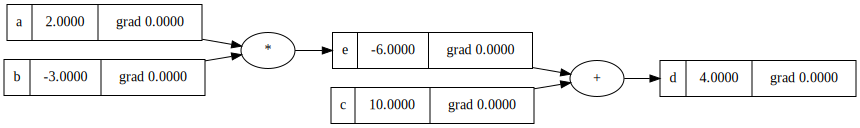

In [10]:
draw_dot(d)

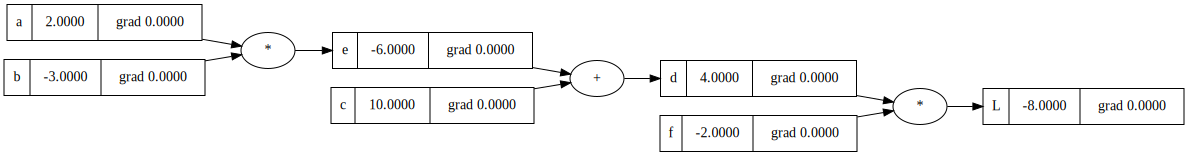

In [11]:
f = Value(-2., label='f')
L = Value(d * f, label='L') # Loss function
draw_dot(L)

In [12]:
# the derivative of L in respect to L is 1
def tmp():
    h = 0.001

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L1 = L.data

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L2 = L.data + h

    return (L2 - L1) / h

tmp()

1.000000000000334

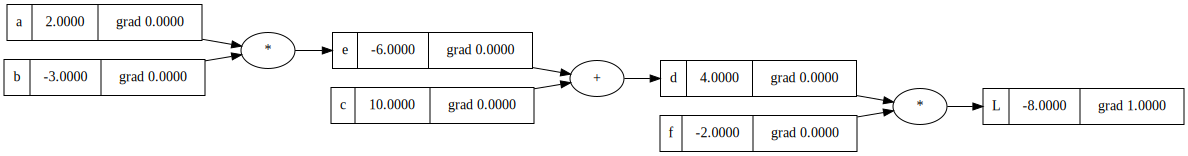

In [13]:
L.grad = 1
draw_dot(L)

In [14]:
# L = d * f
# we want to know
# dL/dd = ?
# dL/dd = f

# (f(x+h) - f(x)) / h # limit of h goes to zero

# ((d+h)*f - d*f)/h
# (d*f + h*f - d*f)/h
# (h*f)/h
# f

In [15]:
f.grad = d.data

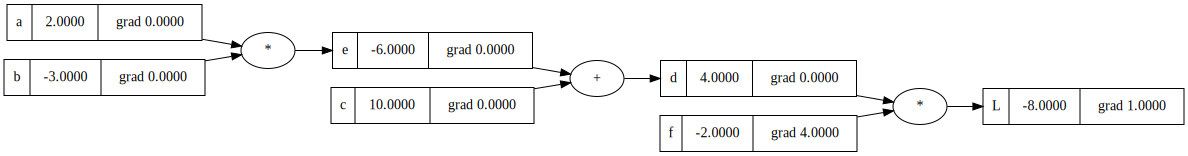

In [16]:
draw_dot(L)

In [17]:
d.grad = f.data

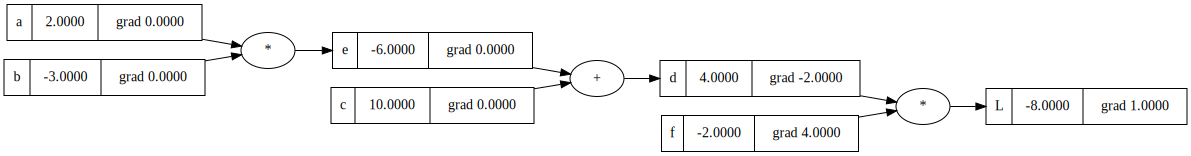

In [18]:
draw_dot(L)

In [19]:
# derivative with respect to f
def tmp():
    h = 0.001

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L1 = L.data

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2. + h , label='f')
    L = Value(d * f, label='L')
    L2 = L.data

    return (L2 - L1) / h

tmp()

3.9999999999995595

In [20]:
# derivative with respect to d
def tmp():
    h = 0.001

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L1 = L.data

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    d.data += h
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L2 = L.data

    return (L2 - L1) / h

tmp()

-2.000000000000668

In [21]:
# dL/dc -> derivative of L with respect to c

In [22]:
# dd/dc -> what is dd by dc?
# d = c + e -> 1
# ((c + h + e) - (c + e))/h
# (c + h + e - c - e)/h
# (h + e - e)/h
# h/h
# 1

In [23]:
# dd/de -> e (local derivative)
# e = a * b
# ((a + h * b) - (a * b))/h
# (a + h * b - a * -b)/h
# (h * b - b)/h
# h/h
# 1

In [23]:
# WANT:
# dL/dc = (dL/dd) * (dd/dc)

# KNOW:
# dL/dd
# dd/dc

In [24]:
c.grad = d.grad * 1
c.grad

-2.0

In [25]:
e.grad = d.grad * 1
e.grad

-2.0

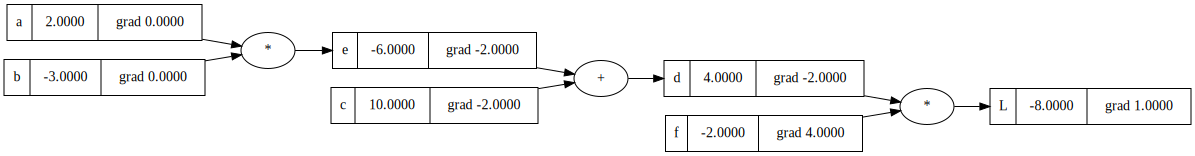

In [26]:
draw_dot(L)

In [27]:
# derivative with respect to c
def tmp():
    h = 0.001

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L1 = L.data

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    c.data += h
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L2 = L.data

    return (L2 - L1) / h

tmp()

-1.9999999999988916

In [28]:
# derivative with respect to e
def tmp():
    h = 0.001

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L1 = L.data

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = Value(a * b, label='e')
    e.data += h
    d = Value(e + c, label='d')
    f = Value(-2., label='f')
    L = Value(d * f, label='L')
    L2 = L.data

    return (L2 - L1) / h

tmp()

-2.000000000000668

In [ ]:
# WANT:
# dL/da = (dL/dd) * (de/da)
# de/da is the local gradient
# de/da is the value of b

# KNOW:
# dL/dd = -2
# dL/dc = -2

In [30]:
a.grad = e.grad * b.data
a.grad

6.0

In [31]:
b.grad = e.grad * a.data
b.grad

-4.0

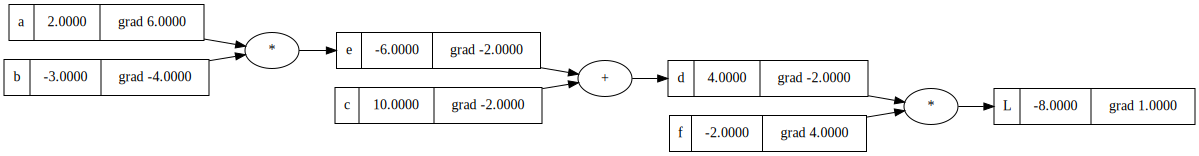

In [32]:
draw_dot(L)